<a href="https://colab.research.google.com/github/Balajinanda/Large-Language-Models/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requ

In [2]:
from datasets import load_dataset
import pandas as pd

# Load the TREC-6 dataset
dataset = load_dataset('trec')

# Inspect the dataset structure
print(dataset)
print(dataset['train'].features)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for trec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/trec.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})
{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NU

In [3]:
# Convert dataset to pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Check the first few rows of the DataFrame to understand the structure
print(train_df.head())
print(test_df.head())

                                                text  coarse_label  fine_label
0  How did serfdom develop in and then leave Russ...             2          26
1   What films featured the character Popeye Doyle ?             1           5
2  How can I find a list of celebrities ' real na...             2          26
3  What fowl grabs the spotlight after the Chines...             1           2
4                    What is the full form of .com ?             0           1
                                       text  coarse_label  fine_label
0      How far is it from Denver to Aspen ?             5          40
1  What county is Modesto , California in ?             4          32
2                         Who was Galileo ?             3          31
3                         What is an atom ?             2          24
4          When did Hawaii become a state ?             5          39


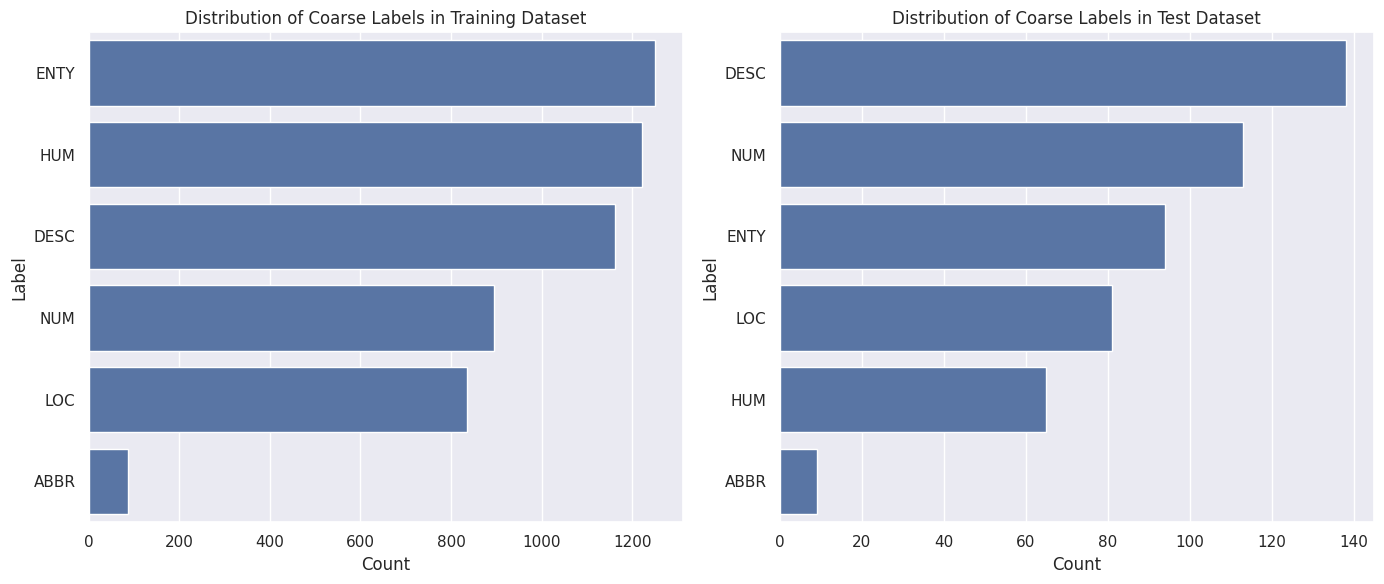

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="darkgrid")

# Count the frequency of each coarse label in the training dataset
train_label_counts = train_df['coarse_label'].value_counts()

# Count the frequency of each coarse label in the test dataset
test_label_counts = test_df['coarse_label'].value_counts()

# Map label IDs to label names
label_names = dataset['train'].features['coarse_label'].names

# Convert label counts to DataFrame for easy plotting
train_label_counts_df = pd.DataFrame({'Label': [label_names[i] for i in train_label_counts.index], 'Count': train_label_counts.values})
test_label_counts_df = pd.DataFrame({'Label': [label_names[i] for i in test_label_counts.index], 'Count': test_label_counts.values})

# Plot the distribution of coarse labels in the training dataset
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Label', data=train_label_counts_df)
plt.title('Distribution of Coarse Labels in Training Dataset')

# Plot the distribution of coarse labels in the test dataset
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Label', data=test_label_counts_df)
plt.title('Distribution of Coarse Labels in Test Dataset')

plt.tight_layout()
plt.show()

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
def preprocess_data(df):
    return tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

train_encodings = preprocess_data(train_df)
test_encodings = preprocess_data(test_df)

# Adjust column names based on inspection
train_labels = train_df['coarse_label']
test_labels = test_df['coarse_label']

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels.values))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels.values))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.train()
for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1


100%|██████████| 43/43 [07:55<00:00, 11.05s/it]


Epoch 2


100%|██████████| 43/43 [07:51<00:00, 10.96s/it]


Epoch 3


100%|██████████| 43/43 [07:54<00:00, 11.04s/it]


Epoch 4


100%|██████████| 43/43 [07:51<00:00, 10.96s/it]


Epoch 5


100%|██████████| 43/43 [07:54<00:00, 11.03s/it]


Epoch 6


100%|██████████| 43/43 [07:52<00:00, 10.99s/it]


Epoch 7


100%|██████████| 43/43 [07:52<00:00, 10.98s/it]


Epoch 8


100%|██████████| 43/43 [07:55<00:00, 11.05s/it]


Epoch 9


100%|██████████| 43/43 [07:55<00:00, 11.06s/it]


Epoch 10


100%|██████████| 43/43 [07:55<00:00, 11.07s/it]


In [10]:
from sklearn.metrics import accuracy_score

model.eval()
preds = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds.extend(torch.argmax(outputs.logits, axis=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9680


In [11]:
model.save_pretrained('./trec6-bert-model')
tokenizer.save_pretrained('./trec6-bert-model')

('./trec6-bert-model/tokenizer_config.json',
 './trec6-bert-model/special_tokens_map.json',
 './trec6-bert-model/vocab.txt',
 './trec6-bert-model/added_tokens.json')

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from datasets import load_dataset

# Load the TREC-6 dataset for label mapping
dataset = load_dataset('trec')

# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained('./trec6-bert-model')
tokenizer = BertTokenizer.from_pretrained('./trec6-bert-model')

# Move the model to the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

# Example new texts for prediction
new_texts = [
    "What is the capital of France?",
    "Who is the CEO of Tesla?",
    "Define photosynthesis.",
    "How many continents are there?",
    "Name a programming language."
]

# Tokenize the new texts
encodings = tokenizer(new_texts, padding=True, truncation=True, return_tensors="pt")

# Move the encodings to the device
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

# Make predictions
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted class labels
predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Map predictions to class names
label_names = dataset['train'].features['coarse_label'].names
predicted_labels = [label_names[pred] for pred in predictions]

# Print the predictions
for text, label in zip(new_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Label: {label}\n")


Text: What is the capital of France?
Predicted Label: LOC

Text: Who is the CEO of Tesla?
Predicted Label: HUM

Text: Define photosynthesis.
Predicted Label: DESC

Text: How many continents are there?
Predicted Label: NUM

Text: Name a programming language.
Predicted Label: ENTY

